In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D
import pydicom

import time
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import torch
import itertools

from scipy.spatial.transform import Rotation as R

from tracking_utils import *
from arm_utils import search_cuboid

#np.seterr(all="ignore")

# camera intrinsics/rig extrinsics 
## (to be modified to pull live data in the future)

In [2]:
intrinsics = load_lut("data/Depth AHaT_lut.bin")
intrinsics_map = np.reshape(intrinsics, (512, 512, -1))

right_intrinsics = load_lut("data/VLC RF_lut.bin")
right_intrinsics = np.reshape(right_intrinsics, (480, 640, -1)) # correct order?
right_intrinsics = np.flip(right_intrinsics, axis=1) # need flip?
riflat = np.reshape(right_intrinsics, (-1,3))

left_intrinsics = load_lut("data/VLC LF_lut.bin")
left_intrinsics = np.reshape(left_intrinsics, (480, 640, -1)) # correct order?
left_intrinsics = np.flip(left_intrinsics, axis=0) # need flip?
liflat = np.reshape(left_intrinsics, (-1,3))

r2d = load_r2c("data/Depth AHaT_extrinsics.txt")
d2r = np.linalg.inv(r2d)
r2right = load_r2c("data/VLC RF_extrinsics.txt")
r2left = load_r2c("data/VLC LF_extrinsics.txt")
d2right = r2right.dot(d2r)
d2left = r2left.dot(d2r)

# load ellipse segmentation model

In [3]:
DEVICE = torch.device('cuda')
ellipsegnet = EllipSegNet(16, 1)
ellipsegnet.load_state_dict(torch.load('py_ellipsegnet.pt', map_location=DEVICE))
ellipsegnet.to(DEVICE)
ellipsegnet.eval()
print('loaded')

loaded


# get pose data (cam2world) for specified session

In [4]:
# time in ms
# transforms in metres
session_name = "06-02-2022-22-03-09"
#14-01-2022-12-22-15 
#14-01-2022-15-48-40

depth_trans = np.reshape(np.loadtxt("data/" + session_name + "/depthextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
depth_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in depth_trans])
left_trans = np.reshape(np.loadtxt("data/" + session_name + "/leftextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
left_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in left_trans])
right_trans = np.reshape(np.loadtxt("data/" + session_name + "/rightextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
right_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in right_trans])

# process and visualize tracked data frame by frame

In [5]:
bright_cut = [500, 0.01] # 500
d_threshold = 50 # 35cm
scales = [15, 20, 30, 40, 60, 120]
delta_threshold = [40, 500] # grab stream data with X ms of left frame

estimated_offset = [0.12, 0.01] # m
roi_padding = 0.02 # m

processed = 0
debug_count = 0
pose = []
angles_tracker = []
pc = []

for idx, left_t in enumerate(left_trans[:,0]):

    #if idx < 410 or idx > 460:
    #    continue
    #if idx < 435 or idx > 436:
    #    continue
    
    closest_right_idx = np.argmin(np.abs(left_t - right_trans[:,0]))
    closest_depth_idx = np.argmin(np.abs(left_t - depth_trans[:,0]))
    if np.abs(right_trans[closest_right_idx,0] - left_t) > delta_threshold[0]:
        print('bad timings, dropping this frame')
        continue
    if np.abs(depth_trans[closest_depth_idx,0] - left_t) > delta_threshold[1]:
        print('bad timings, dropping this frame')
        continue            

    if closest_right_idx != idx:
        #print('idx mismatch: ', closest_right_idx - idx, ' debug_count: ', debug_count)
        debug_count += 1
    #continue
        
    left_image = np.flip(cv2.imread("data/" + session_name + "/left/" + str(left_t) + "_left.pgm").swapaxes(0,1), axis=1)
    right_image = np.flip(cv2.imread("data/" + session_name + "/right/" + str(right_trans[closest_right_idx,0]) + "_right.pgm").swapaxes(0,1), axis=0)
    depth_map = cv2.imread("data/" + session_name + "/depth/" + str(depth_trans[closest_depth_idx,0]) + "_depth.pgm", -1)
    bright_map = cv2.imread("data/" + session_name + "/depth/" + str(depth_trans[closest_depth_idx,0]) + "_abImage.pgm", -1)
    
    # prepare contours
    depth_map[depth_map >= 1000] = 1
    depth_map = depth_map / 1000
    far_map = (depth_map > (d_threshold/100)).astype(int)
    recon_far = (bright_map > bright_cut[0]).astype(int) * far_map
    near_map = (far_map * -1) + 1
    bright_edge = cv2.Sobel(bright_map, cv2.CV_32F, 1, 0) > 1000 #2700
    recon_near = bright_edge.astype(np.uint8)
    recon_near = cv2.dilate(recon_near, np.ones((2,2), np.uint8), iterations = 1)
    recon_near = recon_near * near_map                                                      
    border = cv2.dilate((bright_map < 100).astype(np.uint8), np.ones((7,7), np.uint8))
    recon_near = ((recon_near - border) > 0).astype(np.uint8)
    recon_full = recon_far + recon_near
    contours, _ = cv2.findContours(recon_full.astype(np.uint8), 0, method=cv2.CHAIN_APPROX_NONE)    
    cont1 = [c for c in contours if len(c) > 1]

    # process contours
    ret, imloc, locloc = candidate_search(cont1, depth_map, intrinsics_map, recon_full, 1, verbose=0, triangle_tol=0.0035, sfc_tol=0.035)    
    try:
        if len(imloc) != 1:
            ret = False
    except:
        ret = False
    
    if ret:
        #print('found in depth')
        imloc = imloc[0]
        locloc = locloc[0]
        # get valid projections
        ret, right_pixels, left_pixels = project_onto_stereo(locloc, d2right, d2left, right_intrinsics, left_intrinsics)
    
        if ret:
        
            # do cropping
            right_image1 = right_image.copy()[:,:,0]
            left_image1 = left_image.copy()[:,:,0]      
            bounds = np.linalg.norm(left_pixels[0] - left_pixels[1]) * 0.75
            scale_select = np.argmin(np.abs(bounds-scales))
            bounds = scales[scale_select]    
            patches1 = [static_cropper(left_image1, left_pixels[i], px=bounds) for i in range(len(left_pixels))]
            patches2 = [static_cropper(right_image1, right_pixels[i], px=bounds) for i in range(len(right_pixels))]    

            # do segmentation
            patches_up1 = [cv2.resize(patches1[i], (120, 120)) for i in range(len(patches1))]
            patches_up2 = [cv2.resize(patches2[i], (120, 120)) for i in range(len(patches2))]
            patches_all = np.stack(patches_up1+patches_up2, 0)
            patches_all = torch.from_numpy(np.float32(patches_all/255)).unsqueeze(1)        
            seg_out = torch.sigmoid(ellipsegnet(patches_all.to(DEVICE)))
            seg_out = seg_out.squeeze(1).detach().cpu().numpy()
            seg_out = np.uint8(255*(seg_out>0.5))
            seg_out = [seg_out[i,:,:].squeeze() for i in range(seg_out.shape[0])]
            seg_out_down = [cv2.resize(seg_out[i], patches1[0].shape) for i in range(len(seg_out))]

            # get sub-pixel
            ret, centers = eval_contours(seg_out_down)
            if ret:
                centers += (np.vstack([left_pixels, right_pixels]) - np.array([bounds, bounds]))
                c_left = centers[:3,:]
                c_right = centers[3:,:]

                # get subpixel-accuracy vectors in worldspace (1ms)           
                right2w = right_trans[closest_right_idx][1].copy()
                left2w = left_trans[idx][1].copy()
                oleft, oright, leftpts, rightpts = recover_rays(c_left, c_right, left_intrinsics, right_intrinsics, left2w, right2w)
                ret, end_left, end_right = intersect_solver(oleft, oright, leftpts, rightpts, 0.0012)
    if ret:
        processed += 1
        pose.append([str(left_t), str(right_trans[closest_right_idx,0]), end_left, end_right])
    
    ############################## VIS ##############################
        
    # get 3 axis of each camera, plot together
    # yz flipped for vis, x negatived for vis

    depth_map1 = depth_map.copy()
    bright_map1 = bright_map.copy()
    bright_map1[bright_map1 > 1500] = 1500
    bright_map1 = bright_map1 / 1500    
    depth_map1 = (np.stack((depth_map1, depth_map1, depth_map1)).transpose((1,2,0)) * 255).astype(np.uint8).copy()
    bright_map1 = (np.stack((bright_map1, bright_map1, bright_map1)).transpose((1,2,0)) * 255).astype(np.uint16).copy()

    left_image1 = left_image.copy()
    right_image1 = right_image.copy()    
    if ret:
        cv2.line(right_image1, (c_right[0,0].astype(int), c_right[0,1].astype(int)), (c_right[1,0].astype(int), c_right[1,1].astype(int)), (0,255,0), 2)
        cv2.line(right_image1, (c_right[0,0].astype(int), c_right[0,1].astype(int)), (c_right[2,0].astype(int), c_right[2,1].astype(int)), (0,255,0), 2)
        cv2.line(left_image1, (c_left[0,0].astype(int), c_left[0,1].astype(int)), (c_left[1,0].astype(int), c_left[1,1].astype(int)), (0,255,0), 2)
        cv2.line(left_image1, (c_left[0,0].astype(int), c_left[0,1].astype(int)), (c_left[2,0].astype(int), c_left[2,1].astype(int)), (0,255,0), 2)   
    
    pair_image = np.hstack((left_image1, right_image1))
    #pair_image = np.hstack((depth_map1.astype(np.uint8).copy(), bright_map1.astype(np.uint8).copy()))
  
    print(ret, idx, end='\r')
    cv2.imshow("pair1", pair_image)
    cv2.setWindowTitle('pair1', str(idx))
    key = cv2.waitKey(1)
    if key == ord('q'):
        break  
    
    #if idx >= 300 and ret:
    #    print('exiting at: ', idx)
    #    break
    
print(processed, ' / ', len(left_trans[:,0]))
print('recording time: ', (left_trans[-1,0] - left_trans[0,0])/1000)
cv2.destroyAllWindows()

C:\Users\kianw\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


failed area test
failed area test
bad stereo
failed area test
failed area test
failed area test


C:\Users\kianw\Documents\GitHub\HoloLens2-ResearchMode-Unity\python\tracking_utils.py:411: RuntimeWarning: divide by zero encountered in double_scalars
  if np.abs(area_e[i] - area_e[i+3]) / min_area > area_t: # cannot be more than 40% difference in ellipse area between L/R


failed area test
bad stereo
bad stereo
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border dete

C:\Users\kianw\Documents\GitHub\HoloLens2-ResearchMode-Unity\python\tracking_utils.py:411: RuntimeWarning: divide by zero encountered in double_scalars
  if np.abs(area_e[i] - area_e[i+3]) / min_area > area_t: # cannot be more than 40% difference in ellipse area between L/R


failed area test
failed area test
failed area test
bad stereo
bad stereo
bad stereo5
bad stereo105
bad stereo


C:\Users\kianw\Documents\GitHub\HoloLens2-ResearchMode-Unity\python\tracking_utils.py:411: RuntimeWarning: divide by zero encountered in double_scalars
  if np.abs(area_e[i] - area_e[i+3]) / min_area > area_t: # cannot be more than 40% difference in ellipse area between L/R


failed area test
bad stereo
failed area test8 270 272
failed area test
bad stereo279
failed area test
failed area test
failed area test
bad stereo
failed area test
failed area test
bad stereo
failed area test
bad stereo
bad stereo
bad stereo
failed area test8 320372 380 384 387 426 432445 482 494 522540543
failed area test


C:\Users\kianw\Documents\GitHub\HoloLens2-ResearchMode-Unity\python\tracking_utils.py:411: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(area_e[i] - area_e[i+3]) / min_area > area_t: # cannot be more than 40% difference in ellipse area between L/R
C:\Users\kianw\Documents\GitHub\HoloLens2-ResearchMode-Unity\python\tracking_utils.py:411: RuntimeWarning: divide by zero encountered in double_scalars
  if np.abs(area_e[i] - area_e[i+3]) / min_area > area_t: # cannot be more than 40% difference in ellipse area between L/R


failed area test
failed area test


C:\Users\kianw\Documents\GitHub\HoloLens2-ResearchMode-Unity\python\tracking_utils.py:411: RuntimeWarning: divide by zero encountered in double_scalars
  if np.abs(area_e[i] - area_e[i+3]) / min_area > area_t: # cannot be more than 40% difference in ellipse area between L/R


bad stereo


C:\Users\kianw\Documents\GitHub\HoloLens2-ResearchMode-Unity\python\tracking_utils.py:411: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(area_e[i] - area_e[i+3]) / min_area > area_t: # cannot be more than 40% difference in ellipse area between L/R


failed area test651 677
failed area test
failed area test
failed area test
failed area test
failed area test
failed area test
failed area test
failed area test
failed area test
failed area test
failed area test
bad stereo812 834849 857
bad stereo
failed area test


C:\Users\kianw\Documents\GitHub\HoloLens2-ResearchMode-Unity\python\tracking_utils.py:411: RuntimeWarning: divide by zero encountered in double_scalars
  if np.abs(area_e[i] - area_e[i+3]) / min_area > area_t: # cannot be more than 40% difference in ellipse area between L/R


failed area test
failed area test
bad stereo
bad stereo
failed area test6 947 949
bad stereo
failed area test
failed area test
bad stereo
bad stereo
failed area test1022 1026 1030 1038
bad stereo 1044 1068 1070
failed area test
failed area test
failed area test
failed area test
bad stereo 1161
failed area test
failed area test
failed area test
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
border detected, invalid
417  /  1206
recording time:  105.584


In [6]:
len(pose)

417

In [42]:
def standardize_pose(poses):
    
    world_markers = np.mean(np.array(poses), axis=0)
    world_markers[1:,:] = world_markers[0,:] + ((world_markers[1:,:] - world_markers[0,:]) / np.linalg.norm((world_markers[1:,:] - world_markers[0,:]), axis=1)[:,None])
    cross = np.cross(world_markers[1,:] - world_markers[0,:], world_markers[2,:] - world_markers[0,:])
    cross = cross / np.linalg.norm(cross)
    world_markers = np.vstack((world_markers, world_markers[0,:] + cross))  
    
    return world_markers

In [43]:
# GETTING MARKER TO WORLD 4X4 MATRICES HERE

fit_err = []
project_err = []
M2Ws = []
timestamps = []

for idx in range(len(pose)):
    ts = 0.5*int(pose[idx][0]) + 0.5*int(pose[idx][1])
    world_markers = standardize_pose([pose[idx][2], pose[idx][3]])
    R1, e = R.align_vectors(world_markers[1:,:] - world_markers[0,:], np.eye(3))
    T1 = world_markers[0,:][:,None]
    M2W = np.vstack((np.hstack((R1.as_matrix(), T1)), np.array([0,0,0,1])))
    M2Ws.append(M2W)
    timestamps.append(ts)
    
    perc_err = np.linalg.norm(world_markers[1:,:] - M2W.dot(np.hstack((np.eye(3), np.array([1,1,1])[:,None])).transpose()).transpose()[:,:-1], axis=1)
    fit_err.append(e)
    project_err.append(perc_err)
    
fit_err = np.array(fit_err)
project_err = np.array(project_err)
M2Ws = np.array(M2Ws)
timestamps = np.array(timestamps)
M2Ws[0]

array([[-0.58233743, -0.53451821, -0.61251401,  0.12454965],
       [ 0.10329351, -0.79599229,  0.59642831, -0.0441879 ],
       [-0.80635822,  0.28405381,  0.51874836, -0.42151037],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [9]:
timestamps[0]

1643730992075.0

<IPython.core.display.Javascript object>


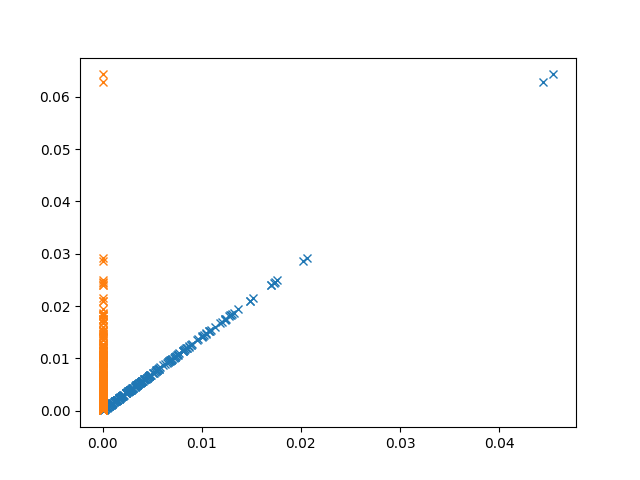

In [233]:
plt.plot(project_err[:,0], fit_err[:], 'x')
plt.plot(project_err[:,2], fit_err[:], 'x')
# X & Y errors strongly correlated with align_vectors err, Z no signnificant error here apparently
# errors stem from tracked markers not being perfectly orthogonal (+-2 degrees, 99%)
# most fall within 2% error, which translates to 3mm @ 15cm / 1mm @ 5cm projection - markers nearer to tip better
# more markers to fit axes can also help to remove per-marker error's influence on transform

In [44]:
# SETTING TIP TO MARKER 4X4 MATRIX HERE

r = R.from_rotvec([0, np.radians(180), 0]).as_matrix()
t = np.array([0.035, -0.121, -0.012])[:,None]
M2T = np.round(np.vstack((np.hstack((r, t)), np.array([0,0,0,1]))), 4)
M2T

array([[-1.   ,  0.   ,  0.   ,  0.035],
       [ 0.   ,  1.   ,  0.   , -0.121],
       [-0.   ,  0.   , -1.   , -0.012],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [45]:
probe_tips_in_world = np.array([[0.00, 0.00, 0, 1],
                                [0.05, 0.00, 0, 1],
                                [0.00, 0.05, 0, 1]]).transpose() # 4x3 homo
probe_tips_in_world = M2Ws[0].dot(np.linalg.inv(M2T).dot(probe_tips_in_world))[:-1,:].transpose()
markers_in_world = np.hstack((np.append(np.array([0, 0, 0])[:,None].transpose(), 0.05*np.eye(3), 0), np.ones(4)[:,None])).transpose() # 3x4 - 4x4 homo
markers_in_world = M2Ws[0].dot(markers_in_world)[:-1, :].transpose()
markers_in_world, probe_tips_in_world

(array([[ 0.12454965, -0.0441879 , -0.42151037],
        [ 0.09543278, -0.03902322, -0.46182828],
        [ 0.09782374, -0.08398751, -0.40730768],
        [ 0.09392395, -0.01436648, -0.39557295]]),
 array([[ 0.04684131, -0.14404483, -0.42158737],
        [ 0.07595818, -0.14920951, -0.38126946],
        [ 0.0201154 , -0.18384445, -0.40738468]]))

<IPython.core.display.Javascript object>


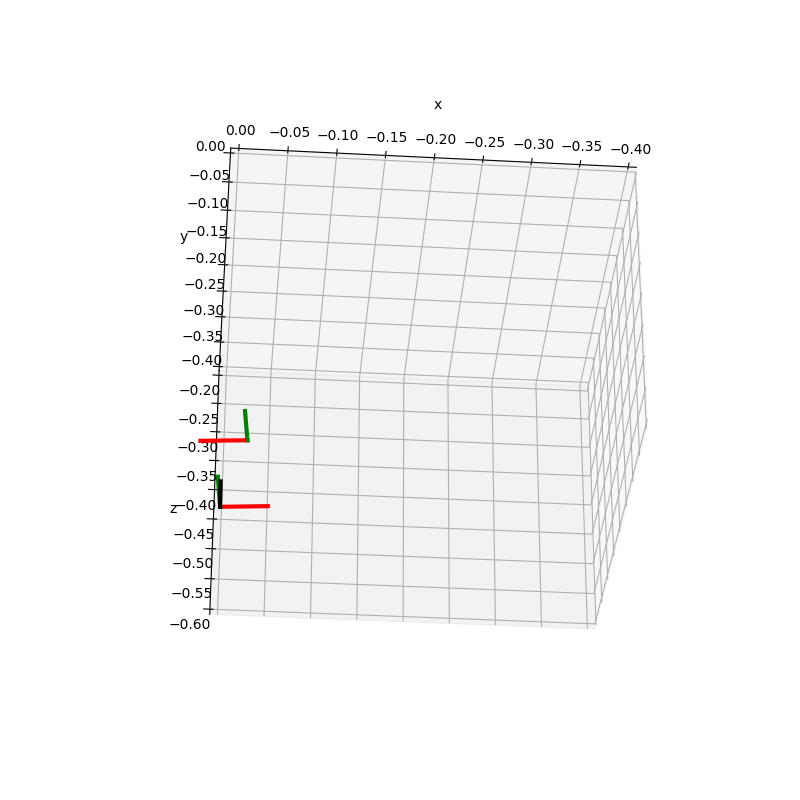

In [292]:
%matplotlib notebook

ax = plt.axes(projection='3d')
ax.figure.set_size_inches(8, 8)
ax.view_init(elev=-47, azim=70)

ax.set_xlabel('x'); ax.set_xlim([-0.4,0.0])
ax.set_ylabel('y'); ax.set_ylim([-0.4,0.0])
ax.set_zlabel('z'); ax.set_zlim([-0.6,-0.2])

ax.plot3D([markers_in_world[0,0], markers_in_world[1,0]], [markers_in_world[0,1], markers_in_world[1,1]], [markers_in_world[0,2], markers_in_world[1,2]], linewidth=3, color='red')
ax.plot3D([markers_in_world[0,0], markers_in_world[2,0]], [markers_in_world[0,1], markers_in_world[2,1]], [markers_in_world[0,2], markers_in_world[2,2]], linewidth=3, color='green')
ax.plot3D([markers_in_world[0,0], markers_in_world[3,0]], [markers_in_world[0,1], markers_in_world[3,1]], [markers_in_world[0,2], markers_in_world[3,2]], linewidth=3, color='black')

ax.plot3D([probe_tips_in_world[0,0], probe_tips_in_world[1,0]], [probe_tips_in_world[0,1], probe_tips_in_world[1,1]], [probe_tips_in_world[0,2], probe_tips_in_world[1,2]], linewidth=3, color='red')
ax.plot3D([probe_tips_in_world[0,0], probe_tips_in_world[2,0]], [probe_tips_in_world[0,1], probe_tips_in_world[2,1]], [probe_tips_in_world[0,2], probe_tips_in_world[2,2]], linewidth=3, color='green')

<IPython.core.display.Javascript object>


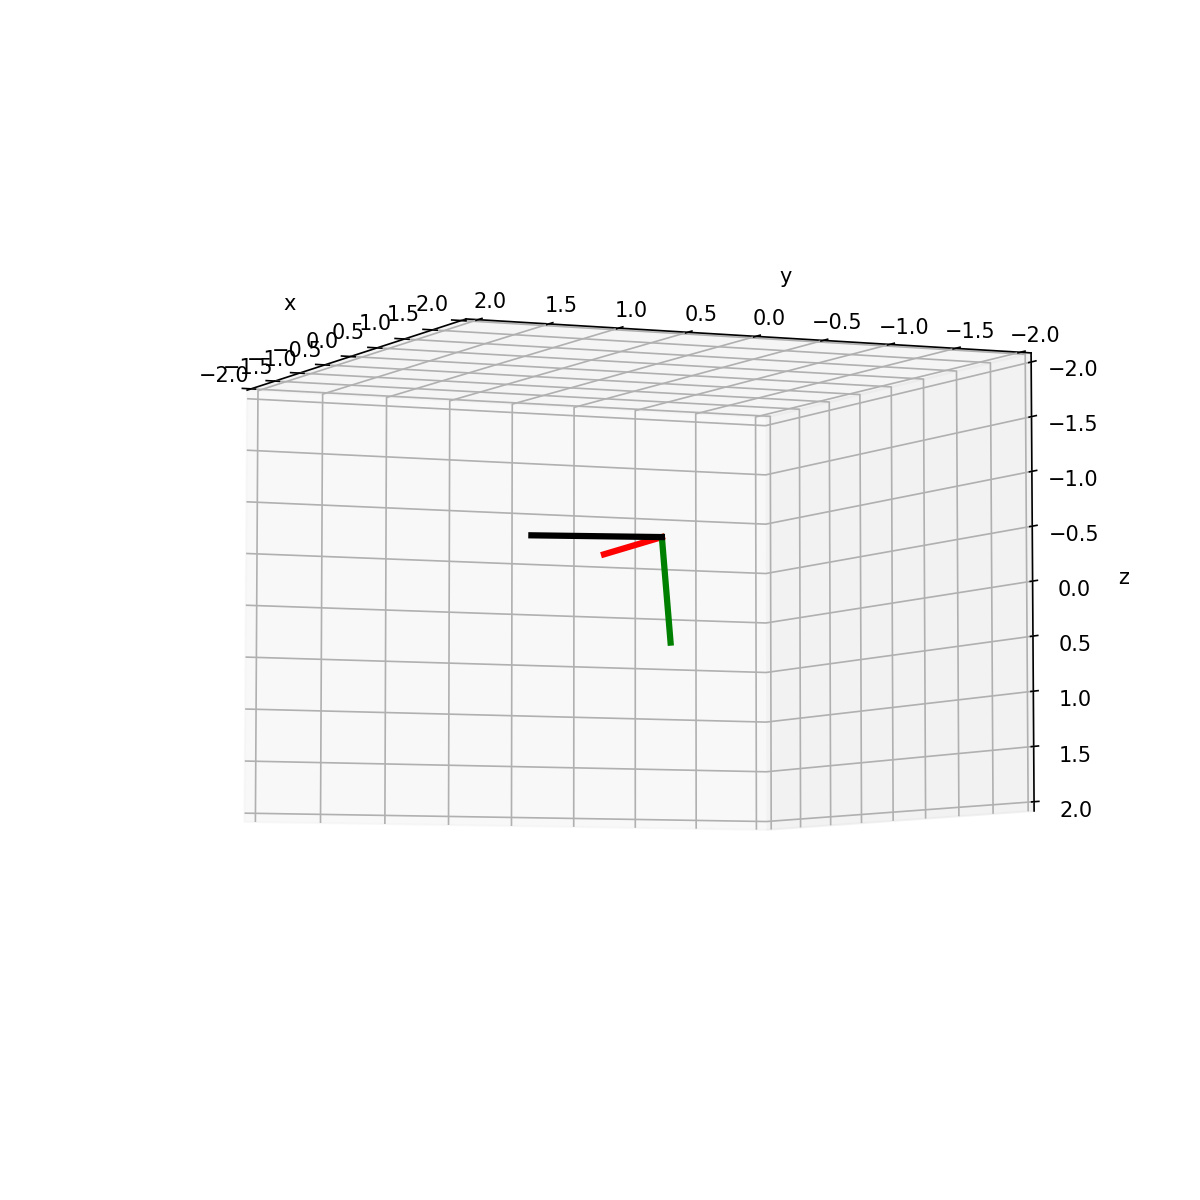

In [107]:
%matplotlib notebook
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(8, 8)
ax.view_init(elev=-111, azim=-107)
ax.set_xlabel('x'); ax.set_xlim([-2,2])
ax.set_ylabel('y'); ax.set_ylim([-2,2])
ax.set_zlabel('z'); ax.set_zlim([-2,2])
ax.plot3D([world_markers[0,0], world_markers[1,0]], [world_markers[0,1], world_markers[1,1]], [world_markers[0,2], world_markers[1,2]], linewidth=3, color='red')
ax.plot3D([world_markers[0,0], world_markers[2,0]], [world_markers[0,1], world_markers[2,1]], [world_markers[0,2], world_markers[2,2]], linewidth=3, color='green')
ax.plot3D([world_markers[0,0], world_markers[3,0]], [world_markers[0,1], world_markers[3,1]], [world_markers[0,2], world_markers[3,2]], linewidth=3, color='black')

# stereo check to sync with ultrasound

In [301]:
delta_threshold = [40, 500] # grab stream data with X ms of left frame

idx = 10
while True:
    left_t = left_trans[idx,0]
    
    closest_right_idx = np.argmin(np.abs(left_t - right_trans[:,0]))
    closest_depth_idx = np.argmin(np.abs(left_t - depth_trans[:,0]))
    if np.abs(right_trans[closest_right_idx,0] - left_t) > delta_threshold[0]:
        #print('bad timings, dropping this frame')
        continue
    if np.abs(depth_trans[closest_depth_idx,0] - left_t) > delta_threshold[1]:
        #print('bad timings, dropping this frame')
        continue            

    if closest_right_idx != idx:
        #print('idx mismatch: ', closest_right_idx - idx, ' debug_count: ', debug_count)
        debug_count += 1
    #continue
        
    left_image = np.flip(cv2.imread("data/" + session_name + "/left/" + str(left_t) + "_left.pgm").swapaxes(0,1), axis=1)
    right_image = np.flip(cv2.imread("data/" + session_name + "/right/" + str(right_trans[closest_right_idx,0]) + "_right.pgm").swapaxes(0,1), axis=0)
    
    pair_image = np.hstack((left_image.astype(np.uint8).copy(), right_image.astype(np.uint8).copy()))
  
    
    cv2.imshow("pair1", pair_image)
    cv2.setWindowTitle('pair1', str(left_t) + ' ' + str(right_trans[closest_right_idx,0]) + ' ' + 
                       str(idx) + ' ' + str(closest_right_idx))
    print(str(left_t) + ' ' + str(right_trans[closest_right_idx,0]), end='\r')
    key = cv2.waitKey(100)
    if key == ord('q'):
        break  
    if key == ord('n'):
        idx += 1
    if idx >= len(left_trans[:,0]):
        break
    
cv2.destroyAllWindows()

In [283]:
# second dataset
# frame 060 start, 1643730985624 - 1643730985656
# frame 100 start, 1643730992125 - 1643730992158
# frame 141 start, 1643730998791 - 1643730998823 
# frame 185 start, 1643731005919 - 1643731005951 
# frame 223 start, 1643731012123 - 1643731012155 
# frame 258 start, 1643731017798 - 1643731017831 
# frame 316 start, 1643731027236 - 1643731027269 
# frame 362 start, 1643731034694 - 1643731034726
# frame 403 start, 1643731041392 - 1643731041360
# frame 442 start, 1643731047696 - 1643731047728
# frame 489 start, 1643731055352 - 1643731055385

# first dataset
# image 32, after 1643636452916, before 1643636452889
# first try starts from dicom-100
# 32 = 1643636452902.5
# 100 = 1000/6 * (100-32) + 1643636452902.5 = 1643636464235.8

In [46]:
check_time = np.array([[60, 1643730985624], # from dicom_viewer, frame 60 is at file_index 45
                       [100, 1643730992125],
                       [141, 1643730998791],
                       [185, 1643731005919],
                       [223, 1643731012123],
                       [258, 1643731017798],
                       [316, 1643731027236],
                       [362, 1643731034694],
                       [403, 1643731041392],
                       [442, 1643731047696],
                       [489, 1643731055352]])

<IPython.core.display.Javascript object>


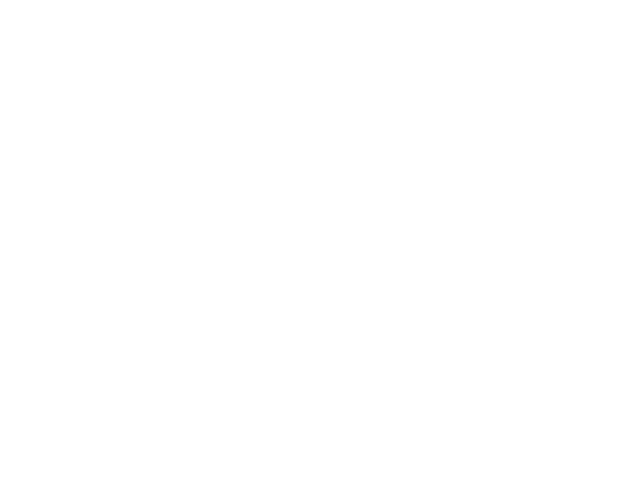

In [47]:
plt.plot(check_time[:,0], check_time[:,1], '-x')

In [48]:
td = (check_time[-1,1] - check_time[0,1])/(check_time[-1,0] - check_time[0,0])
td, 1000/td

(162.53613053613054, 6.152478201009637)

In [49]:
zero_index_time = check_time[0,1] - 45*(td)

# prototype display

In [50]:
dicom_files = glob.glob("data/" + session_name + "/dicom/*")
dicom_timings = np.arange(zero_index_time, zero_index_time+len(dicom_files)*(td), td)

In [16]:
len(dicom_files), len(dicom_timings)

(521, 521)

<IPython.core.display.Javascript object>


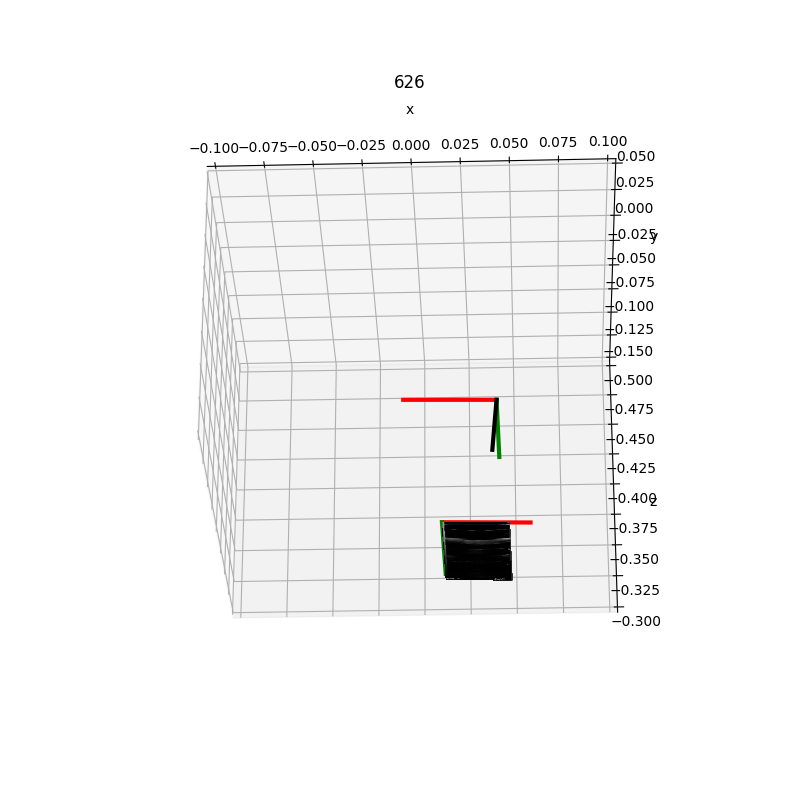

In [60]:
time_offset = 300
save_pose_graphics = True
if save_pose_graphics:
    try:
        os.mkdir("data/" + session_name + "/pose_vis")
    except:
        pass

probe_tips = np.array([[0.00, 0.00, 0, 1],
                                [0.05, 0.00, 0, 1],
                                [0.00, 0.05, 0, 1]]).transpose() # 4x3 homo
markers_tips = np.hstack((np.append(np.array([0, 0, 0])[:,None].transpose(), 0.05*np.eye(3), 0), np.ones(4)[:,None])).transpose() # 3x4 - 4x4 homo
mc = np.load('55mm.npy')

r = R.from_rotvec([0, np.radians(180), 0]).as_matrix()
t = np.array([0.035, -0.121, -0.012])[:,None]
M2T = np.round(np.vstack((np.hstack((r, t)), np.array([0,0,0,1]))), 4)

ax = plt.axes(projection='3d')

for idx in range(len(M2Ws)):
    
    if idx > 626:
        continue
    
    ax.cla()
    ax.figure.set_size_inches(8, 8)
    #ax.view_init(elev=119, azim=-95)
    ax.view_init(elev=151, azim=-92)
    ax.set_xlabel('x'); ax.set_xlim([-0.10,0.10])
    ax.set_ylabel('y'); ax.set_ylim([-0.15,0.05])
    ax.set_zlabel('z'); ax.set_zlim([-0.50,-0.30])
    #print(idx)
    
    marker_time = timestamps[idx]
    best_dicom_idx = np.argmin(np.abs(dicom_timings - time_offset - timestamps[idx]))
    best_dicom_time = dicom_timings[best_dicom_idx] - time_offset

    probe_tips_in_world = M2Ws[idx].dot(np.linalg.inv(M2T).dot(probe_tips))[:-1,:].transpose()
    markers_in_world = M2Ws[idx].dot(markers_tips)[:-1, :].transpose()

    ax.plot3D([markers_in_world[0,0], markers_in_world[1,0]], [markers_in_world[0,1], markers_in_world[1,1]], [markers_in_world[0,2], markers_in_world[1,2]], linewidth=3, color='red')
    ax.plot3D([markers_in_world[0,0], markers_in_world[2,0]], [markers_in_world[0,1], markers_in_world[2,1]], [markers_in_world[0,2], markers_in_world[2,2]], linewidth=3, color='green')
    ax.plot3D([markers_in_world[0,0], markers_in_world[3,0]], [markers_in_world[0,1], markers_in_world[3,1]], [markers_in_world[0,2], markers_in_world[3,2]], linewidth=3, color='black')

    ax.plot3D([probe_tips_in_world[0,0], probe_tips_in_world[1,0]], [probe_tips_in_world[0,1], probe_tips_in_world[1,1]], [probe_tips_in_world[0,2], probe_tips_in_world[1,2]], linewidth=3, color='red')
    ax.plot3D([probe_tips_in_world[0,0], probe_tips_in_world[2,0]], [probe_tips_in_world[0,1], probe_tips_in_world[2,1]], [probe_tips_in_world[0,2], probe_tips_in_world[2,2]], linewidth=3, color='green')
        
    if np.abs(best_dicom_time - marker_time) < 100:# and best_dicom_idx > 100:
        data = pydicom.dcmread(dicom_files[best_dicom_idx])
        image = data.pixel_array[:,:,0]
        image = np.flip(image, axis=1) # added
        dX = data[0x0018,0x6011][0][0x0018, 0x602c].value/100
        dY = data[0x0018,0x6011][0][0x0018, 0x602e].value/100     
        CamIntMat = np.eye(3) * [dX,dY,1]
        Ys, Xs = np.meshgrid(range(image.shape[0]), range(image.shape[1]), indexing='ij')
        Ys = Ys.reshape((-1,1))
        Xs = Xs.reshape((-1,1))
        mc = mc.reshape((-1,1))
        image_coords = np.hstack((np.hstack((Xs, Ys)), np.ones(Xs.shape[0])[:,None])).transpose()
        image_coords = CamIntMat.dot(image_coords)
        image_coords = np.insert(image_coords, 2, 0, axis=0)
        image_in_world = M2Ws[idx].dot(np.linalg.inv(M2T).dot(image_coords))[:-1,:].transpose()
        image_in_world = image_in_world.reshape((image.shape[0], image.shape[1], -3))
        ax.plot_surface(image_in_world[:,:,0], image_in_world[:,:,1], image_in_world[:,:,2], facecolors=(np.tile(image[:,:,None], (1,1,3))/255),
                       linewidth=0, alpha=0.6, edgecolor=None, antialiased=False, rstride=10, cstride=10)        
        ax.set_title(str(idx))
    
    ax.figure.canvas.draw()
    #img = np.frombuffer(ax.figure.canvas.tostring_rgb(), dtype=np.uint8)
    #img  = cv2.cvtColor(img.reshape(ax.figure.canvas.get_width_height()[::-1] + (3,)), cv2.COLOR_BGR2RGB)
    #cv2.imshow("pose", img)
    #cv2.setWindowTitle('pose', str(idx))
    #key = cv2.waitKey(1)
    #if key == ord('q'):
    #    break  
        
    if save_pose_graphics:
        ax.figure.savefig("data/" + session_name + "/pose_vis/" + str(idx).zfill(4) + '.png', dpi=ax.figure.dpi)        
    plt.cla()    

cv2.destroyAllWindows()
plt.close()

<IPython.core.display.Javascript object>


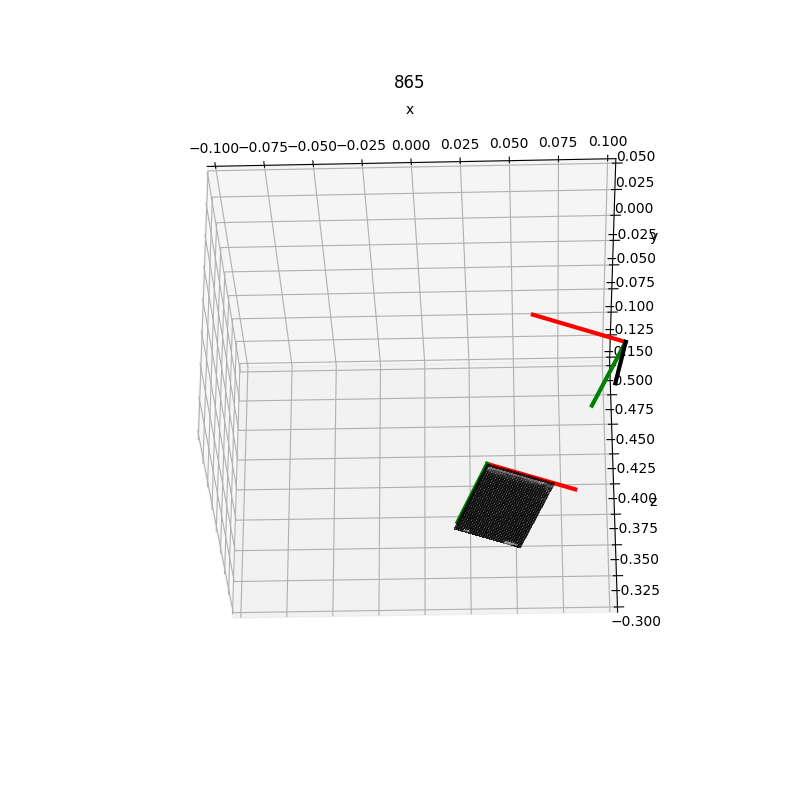

In [386]:
time_offset = 700
save_pose_graphics = True
if save_pose_graphics:
    try:
        os.mkdir("data/" + session_name + "/debugging" + str(time_offset))
    except:
        pass

probe_tips = np.array([[0.00, 0.00, 0, 1],
                                [0.05, 0.00, 0, 1],
                                [0.00, 0.05, 0, 1]]).transpose() # 4x3 homo
markers_tips = np.hstack((np.append(np.array([0, 0, 0])[:,None].transpose(), 0.05*np.eye(3), 0), np.ones(4)[:,None])).transpose() # 3x4 - 4x4 homo
mc = np.load('55mm.npy')

r = R.from_rotvec([0, np.radians(180), 0]).as_matrix()
t = np.array([0.035, -0.121, -0.012])[:,None]
M2T = np.round(np.vstack((np.hstack((r, t)), np.array([0,0,0,1]))), 4)

ax = plt.axes(projection='3d')

for idx in range(len(M2Ws)):
    
    if idx < 626:
        continue
    
    ax.cla()
    ax.figure.set_size_inches(8, 8)
    #ax.view_init(elev=119, azim=-95)
    ax.view_init(elev=151, azim=-92)
    ax.set_xlabel('x'); ax.set_xlim([-0.10,0.10])
    ax.set_ylabel('y'); ax.set_ylim([-0.15,0.05])
    ax.set_zlabel('z'); ax.set_zlim([-0.50,-0.30])
    #print(idx)
    
    marker_time = timestamps[idx]
    best_dicom_idx = np.argmin(np.abs(dicom_timings - time_offset - timestamps[idx]))
    best_dicom_time = dicom_timings[best_dicom_idx] - time_offset

    probe_tips_in_world = M2Ws[idx].dot(np.linalg.inv(M2T).dot(probe_tips))[:-1,:].transpose()
    markers_in_world = M2Ws[idx].dot(markers_tips)[:-1, :].transpose()

    ax.plot3D([markers_in_world[0,0], markers_in_world[1,0]], [markers_in_world[0,1], markers_in_world[1,1]], [markers_in_world[0,2], markers_in_world[1,2]], linewidth=3, color='red')
    ax.plot3D([markers_in_world[0,0], markers_in_world[2,0]], [markers_in_world[0,1], markers_in_world[2,1]], [markers_in_world[0,2], markers_in_world[2,2]], linewidth=3, color='green')
    ax.plot3D([markers_in_world[0,0], markers_in_world[3,0]], [markers_in_world[0,1], markers_in_world[3,1]], [markers_in_world[0,2], markers_in_world[3,2]], linewidth=3, color='black')

    ax.plot3D([probe_tips_in_world[0,0], probe_tips_in_world[1,0]], [probe_tips_in_world[0,1], probe_tips_in_world[1,1]], [probe_tips_in_world[0,2], probe_tips_in_world[1,2]], linewidth=3, color='red')
    ax.plot3D([probe_tips_in_world[0,0], probe_tips_in_world[2,0]], [probe_tips_in_world[0,1], probe_tips_in_world[2,1]], [probe_tips_in_world[0,2], probe_tips_in_world[2,2]], linewidth=3, color='green')
        
    if np.abs(best_dicom_time - marker_time) < 100:# and best_dicom_idx > 100:
        data = pydicom.dcmread(dicom_files[best_dicom_idx])
        image = data.pixel_array[:,:,0]
        image = np.flip(image, axis=1) # added
        dX = data[0x0018,0x6011][0][0x0018, 0x602c].value/100
        dY = data[0x0018,0x6011][0][0x0018, 0x602e].value/100     
        CamIntMat = np.eye(3) * [dX,dY,1]
        Ys, Xs = np.meshgrid(range(image.shape[0]), range(image.shape[1]), indexing='ij')
        Ys = Ys.reshape((-1,1))
        Xs = Xs.reshape((-1,1))
        mc = mc.reshape((-1,1))
        image_coords = np.hstack((np.hstack((Xs, Ys)), np.ones(Xs.shape[0])[:,None])).transpose()
        image_coords = CamIntMat.dot(image_coords)
        image_coords = np.insert(image_coords, 2, 0, axis=0)
        image_in_world = M2Ws[idx].dot(np.linalg.inv(M2T).dot(image_coords))[:-1,:].transpose()
        image_in_world = image_in_world.reshape((image.shape[0], image.shape[1], -3))
        ax.plot_surface(image_in_world[:,:,0], image_in_world[:,:,1], image_in_world[:,:,2], facecolors=(np.tile(image[:,:,None], (1,1,3))/255),
                       linewidth=0, alpha=0.6, edgecolor=None, antialiased=False, rstride=35, cstride=35)        
        ax.set_title(str(idx))
    
    ax.figure.canvas.draw()
    #img = np.frombuffer(ax.figure.canvas.tostring_rgb(), dtype=np.uint8)
    #img  = cv2.cvtColor(img.reshape(ax.figure.canvas.get_width_height()[::-1] + (3,)), cv2.COLOR_BGR2RGB)
    #cv2.imshow("pose", img)
    #cv2.setWindowTitle('pose', str(idx))
    #key = cv2.waitKey(1)
    #if key == ord('q'):
    #    break  
        
    if save_pose_graphics:
        ax.figure.savefig("data/" + session_name + "/debugging" + str(time_offset) + "/" + str(idx).zfill(4) + '.png', dpi=ax.figure.dpi)        
    plt.cla()    

cv2.destroyAllWindows()
plt.close()

<IPython.core.display.Javascript object>


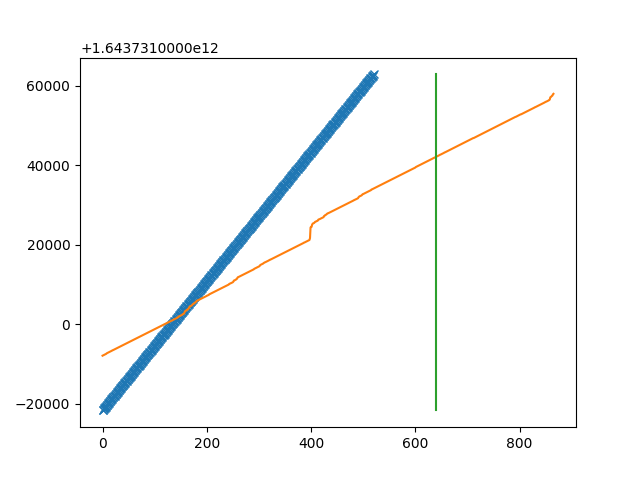

In [373]:
plt.plot(dicom_timings, 'x')
#plt.plot(dicom_timings - 200)
plt.plot(timestamps)
plt.plot([640, 640], [np.min(dicom_timings), np.max(dicom_timings)])

In [335]:
# maybe image origin is top right? probably!!
# image needs some cropping for origin, right bar, 
# check r2w stability - is there a 1-2mm spread? isolate the jerkiness in rendering
# some swishiness, 2-300ms delay from US to screen?
# debug M2W 627-846

In [18]:
pose

[['1643730992091',
  '1643730992059',
  array([[ 0.12454992, -0.04423002, -0.42148723],
         [ 0.10925613, -0.04132513, -0.44295984],
         [ 0.10246479, -0.07755203, -0.40920714]]),
  array([[ 0.12454939, -0.04414577, -0.42153351],
         [ 0.10925495, -0.04101994, -0.44311184],
         [ 0.10246546, -0.07763863, -0.40914631]])],
 ['1643730992158',
  '1643730992125',
  array([[ 0.11236449, -0.04420851, -0.42095613],
         [ 0.09683072, -0.04105959, -0.44141382],
         [ 0.09179506, -0.07777255, -0.40998895]]),
  array([[ 0.11236984, -0.04462015, -0.42072812],
         [ 0.09683424, -0.04136043, -0.44126238],
         [ 0.09180651, -0.07845181, -0.40950961]])],
 ['1643730992223',
  '1643730992191',
  array([[ 0.10462504, -0.0449328 , -0.42363847],
         [ 0.08875581, -0.04226838, -0.44347855],
         [ 0.08472526, -0.07790661, -0.41113098]]),
  array([[ 0.10463505, -0.04557238, -0.42328527],
         [ 0.08875909, -0.0425601 , -0.44333169],
         [ 0.08473332, -

<IPython.core.display.Javascript object>


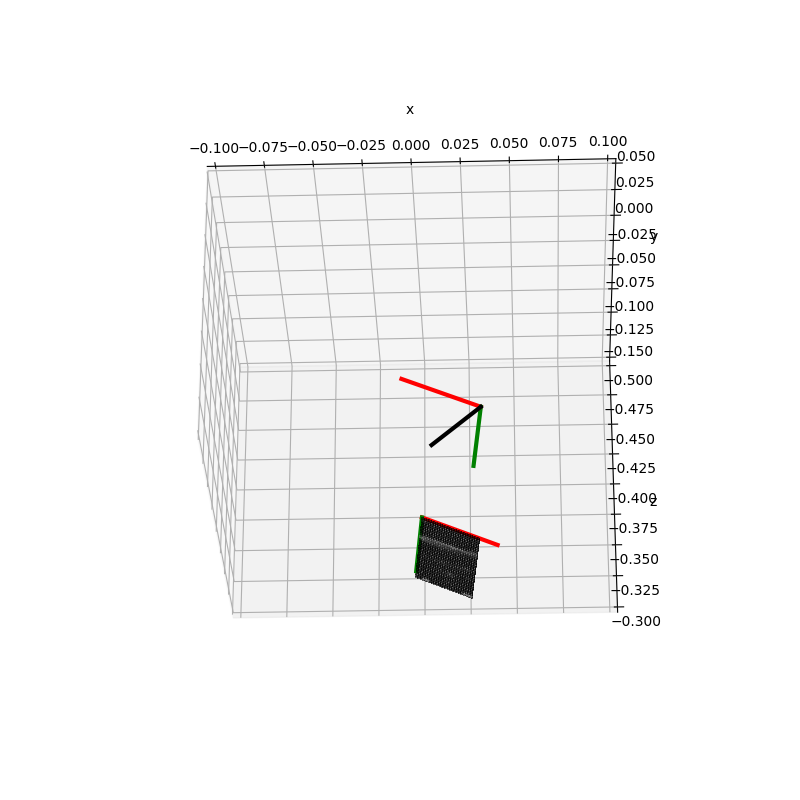

In [307]:
ax = plt.axes(projection='3d')

ax.figure.set_size_inches(8, 8)
ax.view_init(elev=119, azim=-95)
ax.set_xlabel('x'); ax.set_xlim([-0.10,0.10])
ax.set_ylabel('y'); ax.set_ylim([-0.15,0.05])
ax.set_zlabel('z'); ax.set_zlim([-0.50,-0.30])

ax.plot3D([markers_in_world[0,0], markers_in_world[1,0]], [markers_in_world[0,1], markers_in_world[1,1]], [markers_in_world[0,2], markers_in_world[1,2]], linewidth=3, color='red')
ax.plot3D([markers_in_world[0,0], markers_in_world[2,0]], [markers_in_world[0,1], markers_in_world[2,1]], [markers_in_world[0,2], markers_in_world[2,2]], linewidth=3, color='green')
ax.plot3D([markers_in_world[0,0], markers_in_world[3,0]], [markers_in_world[0,1], markers_in_world[3,1]], [markers_in_world[0,2], markers_in_world[3,2]], linewidth=3, color='black')

ax.plot3D([probe_tips_in_world[0,0], probe_tips_in_world[1,0]], [probe_tips_in_world[0,1], probe_tips_in_world[1,1]], [probe_tips_in_world[0,2], probe_tips_in_world[1,2]], linewidth=3, color='red')
ax.plot3D([probe_tips_in_world[0,0], probe_tips_in_world[2,0]], [probe_tips_in_world[0,1], probe_tips_in_world[2,1]], [probe_tips_in_world[0,2], probe_tips_in_world[2,2]], linewidth=3, color='green')
        

In [20]:
len(left_trans), left_trans[0][1].shape

(1144, (4, 4))

In [21]:
translations = np.array([lt[1][:-1,-1] for lt in left_trans])
translations = translations - translations[0,:]

In [22]:
translations.shape

(1144, 3)

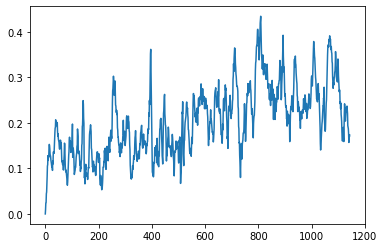

In [23]:
plt.plot(1000*np.sqrt(np.sum(translations ** 2, axis=1)))

# visualization - temporal offset

In [389]:
offsets = [0, 100, 200, 300, 400, 500, 600, 700]
combined_file_list = []
for mag in offsets:
    combined_file_list.append(glob.glob("data/" + session_name + "/debugging" + str(mag) + "/*"))
    #print(len(glob.glob("data/" + session_name + "/debugging" + str(mag) + "/*")))

In [399]:
try:
    os.mkdir("data/" + session_name + "/for_video")
except:
    pass

for frame_idx in range(len(combined_file_list[0])):
    for offset_idx in range(4):
        if offset_idx == 0:
            img1 = cv2.imread(combined_file_list[offset_idx][frame_idx])
        else:
            img1 = np.hstack((img1, cv2.imread(combined_file_list[offset_idx][frame_idx])))
    for offset_idx in range(4):
        if offset_idx == 0:
            img2 = cv2.imread(combined_file_list[offset_idx+4][frame_idx])
        else:
            img2 = np.hstack((img2, cv2.imread(combined_file_list[offset_idx+4][frame_idx])))
    img3 = np.vstack((img1, img2))
    cv2.imwrite("data/"+session_name+"/for_video/"+str(frame_idx).zfill(4)+".png", img3)

In [62]:
import moviepy.video.io.ImageSequenceClip

In [400]:
image_files = glob.glob("data/" + session_name + "/for_video/*.png")
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=20)

In [401]:
clip.write_videofile("data/" + session_name + "/for_video/video.mp4")

Moviepy - Building video data/01-02-2022-23-56-08/for_video/video.mp4.
Moviepy - Writing video data/01-02-2022-23-56-08/for_video/video.mp4



Moviepy - Done !
Moviepy - video ready data/01-02-2022-23-56-08/for_video/video.mp4


In [63]:
image_files = glob.glob("data/" + session_name + "/pose_vis/*.png")
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=20)

In [64]:
clip.write_videofile("data/" + session_name + "/pose_vis/video.mp4")

Moviepy - Building video data/01-02-2022-23-56-08/pose_vis/video.mp4.
Moviepy - Writing video data/01-02-2022-23-56-08/pose_vis/video.mp4



Moviepy - Done !
Moviepy - video ready data/01-02-2022-23-56-08/pose_vis/video.mp4


# analytics - temporal offset

In [53]:
offsets = [0, 100, 200, 300, 400, 500, 600, 700]
all_offset_data = []

for time_offset in offsets:

    #if time_offset != 700:
    #    continue
    
    projected_data = []
    probe_tips = np.array([[0.00, 0.00, 0, 1],
                                    [0.05, 0.00, 0, 1],
                                    [0.00, 0.05, 0, 1]]).transpose() # 4x3 homo
    markers_tips = np.hstack((np.append(np.array([0, 0, 0])[:,None].transpose(), 0.05*np.eye(3), 0), np.ones(4)[:,None])).transpose() # 3x4 - 4x4 homo
    mc = np.load('55mm.npy')
    mc = np.flip(mc, axis=1)

    r = R.from_rotvec([0, np.radians(180), 0]).as_matrix()
    t = np.array([0.035, -0.121, -0.012])[:,None]
    M2T = np.round(np.vstack((np.hstack((r, t)), np.array([0,0,0,1]))), 4)

    for idx in range(len(M2Ws)):

        if idx < 650 or idx > 775:
            continue
        print(time_offset, idx)

        marker_time = timestamps[idx]
        best_dicom_idx = np.argmin(np.abs(dicom_timings - time_offset - timestamps[idx]))
        best_dicom_time = dicom_timings[best_dicom_idx] - time_offset

        probe_tips_in_world = M2Ws[idx].dot(np.linalg.inv(M2T).dot(probe_tips))[:-1,:].transpose()
        markers_in_world = M2Ws[idx].dot(markers_tips)[:-1, :].transpose()

        if np.abs(best_dicom_time - marker_time) < 100:# and best_dicom_idx > 100:
            data = pydicom.dcmread(dicom_files[best_dicom_idx])
            image = data.pixel_array[:,:,0]
            image = np.flip(image, axis=1) # added
            dX = data[0x0018,0x6011][0][0x0018, 0x602c].value/100
            dY = data[0x0018,0x6011][0][0x0018, 0x602e].value/100     
            CamIntMat = np.eye(3) * [dX,dY,1]
            Ys, Xs = np.meshgrid(range(image.shape[0]), range(image.shape[1]), indexing='ij')
            Ys = Ys.reshape((-1,1))
            Xs = Xs.reshape((-1,1))
            image_coords = np.hstack((np.hstack((Xs, Ys)), np.ones(Xs.shape[0])[:,None])).transpose()
            image_coords = CamIntMat.dot(image_coords)
            image_coords = np.insert(image_coords, 2, 0, axis=0)
            image_in_world = M2Ws[idx].dot(np.linalg.inv(M2T).dot(image_coords))[:-1,:].transpose()
            image_in_world = image_in_world.reshape((image.shape[0], image.shape[1], -3))
            
            image1 = image.astype(float).copy()
            image1[mc==1] = np.nan
            
            projected_data.append(np.hstack((image_in_world.reshape((-1,3)), image1.reshape(-1,1))))
    
    projected_data = np.array(projected_data)
    projected_data = projected_data.reshape(-1, 4)
    subset_thresh = projected_data[projected_data[:,3] > 200, :]
    all_offset_data.append(subset_thresh[::101,:-1])

0 650
0 651
0 652
0 653
0 654
0 655
0 656
0 657
0 658
0 659
0 660
0 661
0 662
0 663
0 664
0 665
0 666
0 667
0 668
0 669
0 670
0 671
0 672
0 673
0 674
0 675
0 676
0 677
0 678
0 679
0 680
0 681
0 682
0 683
0 684
0 685
0 686
0 687
0 688
0 689
0 690
0 691
0 692
0 693
0 694
0 695
0 696
0 697
0 698
0 699
0 700
0 701
0 702
0 703
0 704
0 705
0 706
0 707
0 708
0 709
0 710
0 711
0 712
0 713
0 714
0 715
0 716
0 717
0 718
0 719
0 720
0 721
0 722
0 723
0 724
0 725
0 726
0 727
0 728
0 729
0 730
0 731
0 732
0 733
0 734
0 735
0 736
0 737
0 738
0 739
0 740
0 741
0 742
0 743
0 744
0 745
0 746
0 747
0 748
0 749
0 750
0 751
0 752
0 753
0 754
0 755
0 756
0 757
0 758
0 759
0 760
0 761
0 762
0 763
0 764
0 765
0 766
0 767
0 768
0 769
0 770
0 771
0 772
0 773
0 774
0 775
100 650
100 651
100 652
100 653
100 654
100 655
100 656
100 657
100 658
100 659
100 660
100 661
100 662
100 663
100 664
100 665
100 666
100 667
100 668
100 669
100 670
100 671
100 672
100 673
100 674
100 675
100 676
100 677
100 678
100 679
100 

In [54]:
print(len(all_offset_data))
for data in all_offset_data:
    print(data.shape)

8
(63019, 3)
(62332, 3)
(62297, 3)
(61660, 3)
(61326, 3)
(60997, 3)
(61125, 3)
(60840, 3)


<IPython.core.display.Javascript object>


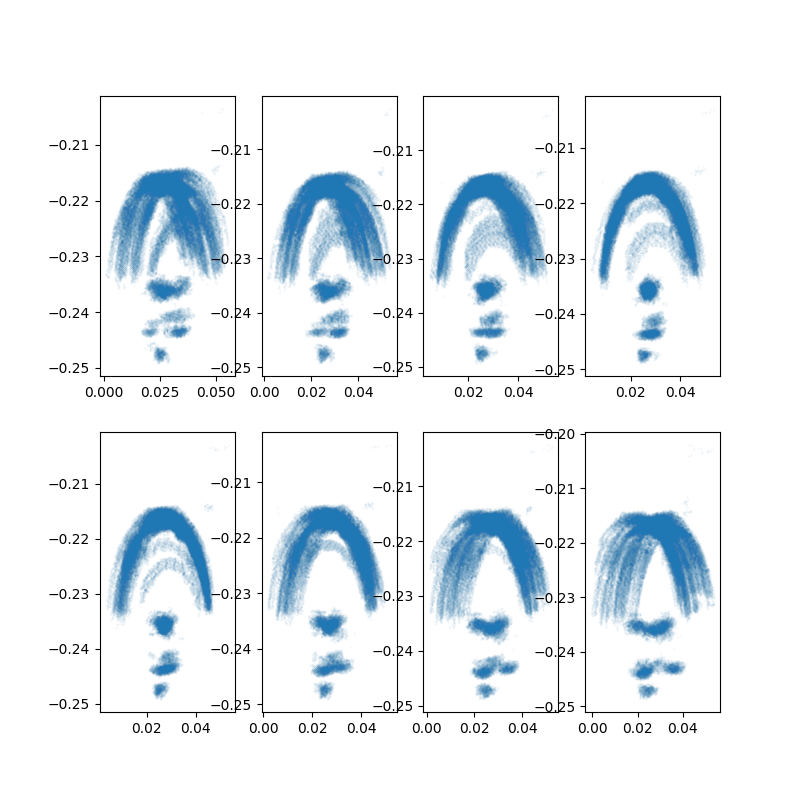

In [58]:
ax = plt.axes()
ax.figure.set_size_inches(8, 8)
for idx, data in enumerate(all_offset_data):
    plt.subplot(2, 4, idx+1)
    plt.scatter(data[:,0], data[:,1], alpha=0.1, s=0.1)

# roughly ideal temporal offset, collating across session

In [16]:
time_offset = 300
int_thresh = 230

projected_data = []
probe_tips = np.array([[0.00, 0.00, 0, 1],
                                [0.05, 0.00, 0, 1],
                                [0.00, 0.05, 0, 1]]).transpose() # 4x3 homo
markers_tips = np.hstack((np.append(np.array([0, 0, 0])[:,None].transpose(), 0.05*np.eye(3), 0), np.ones(4)[:,None])).transpose() # 3x4 - 4x4 homo
mc = np.load('55mm.npy')
mc = np.flip(mc, axis=1)

r = R.from_rotvec([0, np.radians(180), 0]).as_matrix()
t = np.array([0.035, -0.121, -0.012])[:,None]
M2T = np.round(np.vstack((np.hstack((r, t)), np.array([0,0,0,1]))), 4)

for idx in range(len(M2Ws)):

    #if idx < 200 or idx > 300:
    #    continue
    print(idx, end='\r')

    marker_time = timestamps[idx]
    best_dicom_idx = np.argmin(np.abs(dicom_timings - time_offset - timestamps[idx]))
    best_dicom_time = dicom_timings[best_dicom_idx] - time_offset

    probe_tips_in_world = M2Ws[idx].dot(np.linalg.inv(M2T).dot(probe_tips))[:-1,:].transpose()
    markers_in_world = M2Ws[idx].dot(markers_tips)[:-1, :].transpose()

    if np.abs(best_dicom_time - marker_time) < 100:# and best_dicom_idx > 100:
        data = pydicom.dcmread(dicom_files[best_dicom_idx])
        image = data.pixel_array[:,:,0]
        image = np.flip(image, axis=1) # added
        dX = data[0x0018,0x6011][0][0x0018, 0x602c].value/100
        dY = data[0x0018,0x6011][0][0x0018, 0x602e].value/100     
        CamIntMat = np.eye(3) * [dX,dY,1]
        Ys, Xs = np.meshgrid(range(image.shape[0]), range(image.shape[1]), indexing='ij')
        Ys = Ys.reshape((-1,1))
        Xs = Xs.reshape((-1,1))
        image_coords = np.hstack((np.hstack((Xs, Ys)), np.ones(Xs.shape[0])[:,None])).transpose()
        image_coords = CamIntMat.dot(image_coords)
        image_coords = np.insert(image_coords, 2, 0, axis=0)
        image_in_world = M2Ws[idx].dot(np.linalg.inv(M2T).dot(image_coords))[:-1,:].transpose()
        image_in_world = 1000 * image_in_world.reshape((image.shape[0], image.shape[1], -3))

        image1 = image.astype(float).copy()
        image1[mc==1] = np.nan
        to_append = np.hstack((image_in_world.reshape((-1,3)), image1.reshape(-1,1)))
        to_append = to_append[to_append[:,-1] > int_thresh, :-1]
        
        projected_data.append(to_append)

#projected_data = np.array(projected_data)
#projected_data = projected_data.reshape(-1, 4)

KeyboardInterrupt: 

In [35]:
projected_data

[array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape

<IPython.core.display.Javascript object>


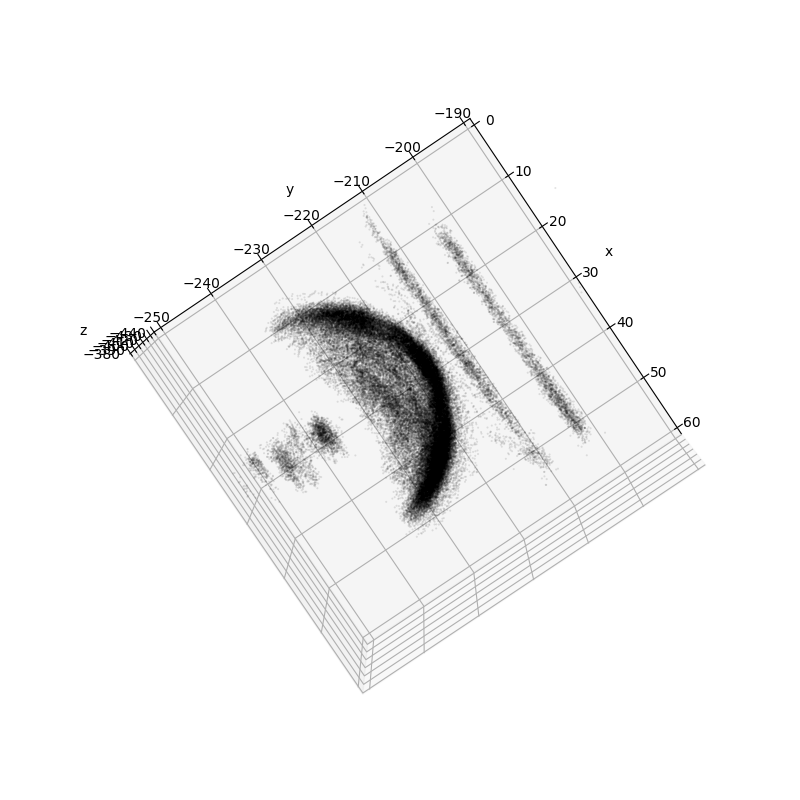

In [40]:
%matplotlib notebook

int_thresh = 230
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(8, 8)
ax.set_xlabel('x'); ax.set_xlim([0,60])
ax.set_ylabel('y'); ax.set_ylim([-250,-190])
ax.set_zlabel('z'); ax.set_zlim([-440,-380])

for sub_slice in projected_data:
    ax.scatter3D(sub_slice[::251, 0], sub_slice[::251, 1], sub_slice[::251, 2], alpha=0.1, s=0.25, c='black')

In [51]:
x_bound = [0,60]
y_bound = [-250,-190] #[-250,-190]
z_bound = [-440,-380]
resolution = 0.5 #0.1

In [52]:
x_ = np.linspace(x_bound[0], x_bound[1], int((1/resolution)*(x_bound[1]-x_bound[0])+1))
y_ = np.linspace(y_bound[0], y_bound[1], int((1/resolution)*(y_bound[1]-y_bound[0])+1))
z_ = np.linspace(z_bound[0], z_bound[1], int((1/resolution)*(z_bound[1]-z_bound[0])+1))
voxel_origin = [x_bound[0], y_bound[0], z_bound[0]]
voxel_origin

[0, -250, -440]

In [53]:
#x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
#voxel_coords = np.stack((x,y,z), -1)
#del x; del y; del z;
#voxel_coords.shape

In [54]:
%matplotlib notebook
"""
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(8, 8)
ax.view_init(elev=-47, azim=70)

ax.set_xlabel('x'); ax.set_xlim([-0.4,0.0])
ax.set_ylabel('y'); ax.set_ylim([-0.4,0.0])
ax.set_zlabel('z'); ax.set_zlim([-0.6,-0.2])
"""

time_offset = 300
value = np.zeros((x_.shape[0], y_.shape[0], z_.shape[0]))
counter = np.zeros((x_.shape[0], y_.shape[0], z_.shape[0]))
print('storage dimensions: ', value.shape)

probe_tips = np.array([[0.00, 0.00, 0, 1],
                                [0.05, 0.00, 0, 1],
                                [0.00, 0.05, 0, 1]]).transpose() # 4x3 homo
markers_tips = np.hstack((np.append(np.array([0, 0, 0])[:,None].transpose(), 0.05*np.eye(3), 0), np.ones(4)[:,None])).transpose() # 3x4 - 4x4 homo
mc = np.load('55mm.npy')
mc = np.flip(mc, axis=1)

r = R.from_rotvec([0, np.radians(180), 0]).as_matrix()
t = np.array([0.035, -0.121, -0.012])[:,None]
M2T = np.round(np.vstack((np.hstack((r, t)), np.array([0,0,0,1]))), 4)

for idx in range(len(M2Ws)):#range(521,533,1)

    print(idx, end='\r')

    marker_time = timestamps[idx]
    best_dicom_idx = np.argmin(np.abs(dicom_timings - time_offset - timestamps[idx]))
    best_dicom_time = dicom_timings[best_dicom_idx] - time_offset

    probe_tips_in_world = M2Ws[idx].dot(np.linalg.inv(M2T).dot(probe_tips))[:-1,:].transpose()
    markers_in_world = M2Ws[idx].dot(markers_tips)[:-1, :].transpose()

    if np.abs(best_dicom_time - marker_time) < 100:
        data = pydicom.dcmread(dicom_files[best_dicom_idx])
        image = data.pixel_array[:,:,0]
        image = np.flip(image, axis=1) # added
        dX = data[0x0018,0x6011][0][0x0018, 0x602c].value/100
        dY = data[0x0018,0x6011][0][0x0018, 0x602e].value/100     
        CamIntMat = np.eye(3) * [dX,dY,1]
        Ys, Xs = np.meshgrid(range(image.shape[0]), range(image.shape[1]), indexing='ij')
        Ys = Ys.reshape((-1,1))
        Xs = Xs.reshape((-1,1))
        image_coords = np.hstack((np.hstack((Xs, Ys)), np.ones(Xs.shape[0])[:,None])).transpose()
        image_coords = CamIntMat.dot(image_coords)
        image_coords = np.insert(image_coords, 2, 0, axis=0)
        image_in_world = M2Ws[idx].dot(np.linalg.inv(M2T).dot(image_coords))[:-1,:].transpose()
        image_in_world = 1000 * image_in_world.reshape((image.shape[0], image.shape[1], -3))

        image1 = image.astype(float).copy()
        image1[mc==1] = np.nan
        to_append = np.hstack((image_in_world.reshape((-1,3)), image1.reshape(-1,1)))
        
        # discard invalid pixels
        to_append = to_append[~np.isnan(to_append[:,-1]), :]
        # discretize to specified resolution
        to_append = np.round(to_append*(1/resolution))/(1/resolution)
        # sorting by x,y,z, and ordered interally by pixel value
        to_append = to_append[to_append[:, 3].argsort()]
        to_append = to_append[to_append[:, 2].argsort(kind='mergesort')]
        to_append = to_append[to_append[:, 1].argsort(kind='mergesort')]
        to_append = to_append[to_append[:, 0].argsort(kind='mergesort')]
        # getting the sample intervals for each unique 3d location
        diff_sorted = np.sum(np.abs(np.diff(to_append[:,:-1], axis=0) > 0), axis=1)       
        new_start = np.append([0],np.where(diff_sorted)[0] + 1)
        new_end = np.append((new_start - 1)[1:], [to_append.shape[0]-1])
        intervals = np.stack((new_start, new_end))
        # get the median pixel values for each 3d location (mean of interval start-stop gives median)
        medians_idx = np.floor(np.mean(intervals, axis=0)).astype(int)
        to_append = to_append[medians_idx, :]
        # instead of exhaustive comparison, these lines direclty give us the voxel indices to attribute to
        to_append[:,:-1] = to_append[:,:-1] - voxel_origin
        to_append[:,:-1] = np.round(to_append[:,:-1] / resolution).astype(int)
        # keep within bounds (#cover lower bound!)
        criteria = ((to_append[:,:-1] - value.shape) >= 0) | (to_append[:,:-1] < 0)
        to_append = (to_append[np.sum(criteria, axis=1) == 0, :]).astype(int)

        value[to_append[:,0], to_append[:,1], to_append[:,2]] += to_append[:,-1]
        counter[to_append[:,0], to_append[:,1], to_append[:,2]] += 1
        
        
    #if idx == 10:
    #    break

storage dimensions:  (121, 121, 121)


<IPython.core.display.Javascript object>


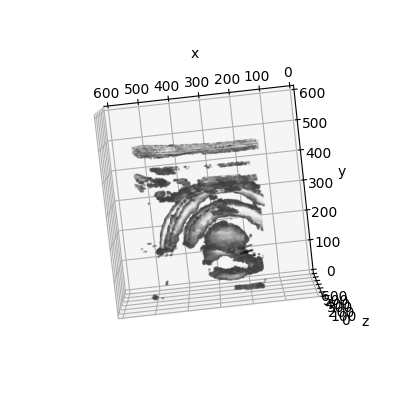

In [205]:
%matplotlib notebook

step = 3
s = 0.5
alpha = 0.2

ax = plt.axes(projection='3d')
ax.figure.set_size_inches(4, 4)
ax.view_init(elev=-140, azim=170)

ax.set_xlabel('x'); ax.set_xlim([0,601])
ax.set_ylabel('y'); ax.set_ylim([0,601])
ax.set_zlabel('z'); ax.set_zlim([0,601])

#locs = np.asarray(np.where(counter))
locs = np.asarray(np.where(value > 100))
mag = value[locs[0,:], locs[1,:], locs[2,:]] / counter[locs[0,:], locs[1,:], locs[2,:]]

ax.scatter3D(locs[0,::step], locs[1,::step], locs[2,::step], c=mag[::step], 
             cmap='gray', s=s, alpha=alpha)

#for azim in range(-50,50,2):
#    ax.view_init(elev=-40, azim=azim)
#    ax.figure.canvas.draw()

In [57]:
value.shape

(121, 121, 121)

In [56]:
np.max(value)

5538.0

In [55]:
np.savez("mean_of_median_0p5mm", value.astype(np.uint16), counter.astype(np.uint8))

<IPython.core.display.Javascript object>


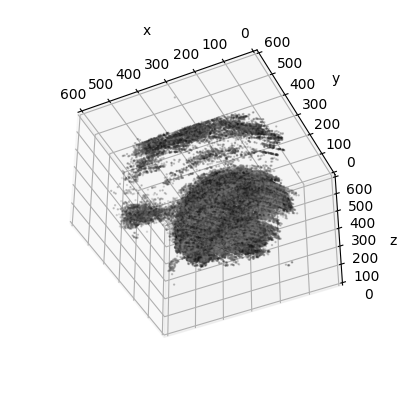

(3, 1280566)


In [21]:
%matplotlib notebook

step = 15
s = 0.5
alpha = 0.2

ax = plt.axes(projection='3d')
ax.figure.set_size_inches(4, 4)
ax.view_init(elev=-140, azim=170)

ax.set_xlabel('x'); ax.set_xlim([0,601])
ax.set_ylabel('y'); ax.set_ylim([0,601])
ax.set_zlabel('z'); ax.set_zlim([0,601])

locs = np.asarray(np.where(mag > 200))
color = mag[locs[0,:], locs[1,:], locs[2,:]]

print(locs.shape)

ax.scatter3D(locs[0,::step], locs[1,::step], locs[2,::step], c=color[::step], 
             cmap='gray', s=s, alpha=alpha, vmax=300)

In [1]:
import numpy as np
import plotly.graph_objects as go

loaded_file = np.load("mean_of_median_0p5mm.npz")

In [2]:
value = loaded_file['arr_0']
counter = loaded_file['arr_1']

In [3]:
mag = value / counter
#mag = mag[200:350, 200:350, 200:350]
mag[mag == np.inf] = 0
mag[mag == np.nan] = 0
print(mag.shape)

(121, 121, 121)


<ipython-input-3-36287e9b6f30>:1: RuntimeWarning: invalid value encountered in true_divide
  mag = value / counter


In [4]:
x1 = np.arange(0, mag.shape[0], 1)#.astype(np.uint16)
y1 = np.arange(0, mag.shape[1], 1)#.astype(np.uint16)
z1 = np.arange(0, mag.shape[2], 1)#.astype(np.uint16) 

X, Y, Z = np.meshgrid(x1, y1, z1)
  
values = mag.copy()
#values = mag.astype(np.uint8)

In [7]:
"""
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    opacity=0.1, 
    isomin=50,
    isomax=255,
    #caps= dict(x_show=False, y_show=False, z_show=True),
    ))
fig.show()
"""

'\nfig = go.Figure(data=go.Volume(\n    x=X.flatten(),\n    y=Y.flatten(),\n    z=Z.flatten(),\n    value=values.flatten(),\n    opacity=0.1, \n    isomin=50,\n    isomax=255,\n    #caps= dict(x_show=False, y_show=False, z_show=True),\n    ))\nfig.show()\n'

<ipython-input-18-43c8d4400b90>:5: RuntimeWarning:

invalid value encountered in true_divide



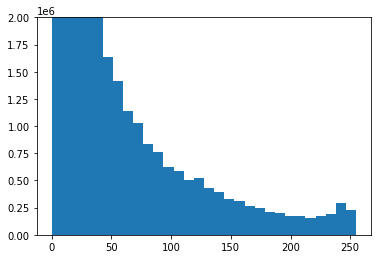

In [18]:
import matplotlib.pyplot as plt
loaded_file1 = np.load("mean_of_median_0p1mm.npz")
value1 = loaded_file1['arr_0']
counter1 = loaded_file1['arr_1']
plt.hist((value1/counter1).flatten(), bins=30)
plt.ylim([0, 0.2e7])
plt.show()